In [1]:
import numpy as np
import pandas as pd
from openscm_units import unit_registry  # pip install openscm-units
from openscm_twolayermodel import ImpulseResponseModel, TwoLayerModel, constants  # pip install openscm-twolayermodel
from scmdata import ScmRun  # pip install scmdata

/Users/znicholls/Documents/AGCEC/MCastle/openscm-twolayermodel/src/openscm_twolayermodel/base.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman


In [2]:
recommend_paras = pd.read_csv("recommended_irf_from_2xCO2_2021_02_25_222758.csv").iloc[0, :]
recommend_paras

id                          recommendation
C (W yr / m^2 / K)                 7.64979
C_d (W yr / m^2 / K)               147.169
alpha (W / m^2 / K)                   1.31
eta (dimensionless)                1.02786
kappa (W / m^2 / K)               0.880636
d1 (yr)                             3.4241
d2 (yr)                            285.003
q1 (K / (W / m^2))                0.443768
q2 (K / (W / m^2))                0.319591
efficacy (dimensionless)           1.02786
ecs (K)                                  3
tcr (K)                            1.80105
rf2xCO2 (W / m^2)                     3.93
Name: 0, dtype: object

In [3]:
erf = np.arange(200) * 4 / 70
scenario = "1pctCO2"
unit = "W/m^2"

driver = ScmRun(
    data=erf,
    index=1850 + np.arange(len(erf)),
    columns={
        "unit": unit,
        "model": "custom",
        "scenario": scenario,
        "region": "World",
        "variable": "Effective Radiative Forcing",
    },
)
driver

<scmdata.ScmRun (timeseries: 1, timepoints: 200)>
Time:
	Start: 1850-01-01T00:00:00
	End: 2049-01-01T00:00:00
Meta:
	    model region scenario   unit                     variable
	0  custom  World  1pctCO2  W/m^2  Effective Radiative Forcing

In [4]:
du = (
    recommend_paras["C (W yr / m^2 / K)"] 
    * unit_registry("W yr / m^2 / delta_degC")
    / constants.DENSITY_WATER
    / constants.HEAT_CAPACITY_WATER
).to("m")
display(du)

dl = (
    recommend_paras["C_d (W yr / m^2 / K)"] 
    * unit_registry("W yr / m^2 / delta_degC")
    / constants.DENSITY_WATER
    / constants.HEAT_CAPACITY_WATER
).to("m")
display(dl)


57.739533588502034 <Unit('meter')>

1110.8078463278985 <Unit('meter')>

In [5]:
two_layer = TwoLayerModel(
    # the naming is confusing because I follow Geoffroy, Ch. 7 Appendix does its own thing
    # the units should be clear
    lambda0=recommend_paras["alpha (W / m^2 / K)"] * unit_registry("W/m^2/delta_degC"),
    du=du,
    dl=dl,
    a=0.0 * unit_registry("watt / delta_degree_Celsius ** 2 / meter ** 2"),
    efficacy=recommend_paras["efficacy (dimensionless)"] * unit_registry("dimensionless"),
    eta=recommend_paras["kappa (W / m^2 / K)"] * unit_registry("W / m^2 / K")
)
res_two_layer = two_layer.run_scenarios(driver)

impulse_response = ImpulseResponseModel(
    d1=recommend_paras["d1 (yr)"] * unit_registry("yr"),
    d2=recommend_paras["d2 (yr)"] * unit_registry("yr"),
    q1=recommend_paras["q1 (K / (W / m^2))"] * unit_registry("delta_degC / (W / m^2)"),
    q2=recommend_paras["q2 (K / (W / m^2))"] * unit_registry("delta_degC / (W / m^2)"),
    efficacy=recommend_paras["efficacy (dimensionless)"] * unit_registry("dimensionless"),
)
res_impulse_response = impulse_response.run_scenarios(driver)

res = res_two_layer.append(res_impulse_response)
res.head()

time                                                                                                                                                                                                                                                                                                                                                                                                        1850-01-01  \
a (watt / delta_degree_Celsius ** 2 / meter ** 2) climate_model                  d1 (a)   d2 (a)     dl (meter)  du (meter) efficacy (dimensionless) eta (watt / kelvin / meter ** 2) lambda0 (watt / delta_degree_Celsius / meter ** 2) model  q1 (delta_degree_Celsius * meter ** 2 / watt) q2 (delta_degree_Celsius * meter ** 2 / watt) region run_idx scenario unit       variable                                  
0.0                                               two_layer                      NaN      NaN        1110.807846 57.739534  1.027856                 0.880636                         1.31                                               custom NaN                                           NaN                                           World  0       1pctCO2  W/m^2      Effective Radiative Forcing         0.0   
                                                                                                                                                                                                                                                                                                                                                                    delta_degC Surface Temperature|Upper           0.0   
                                                                                                                                                                                                                                                                                                                                                                               Surface Temperature|Lower           0.0   
                                                                                                                                                                                                                                                                                                                                                                    W/m^2      Heat Uptake                         0.0   
NaN                                               two_timescale_impulse_response 3.424102 285.003478 NaN         NaN        1.027856                 NaN                              NaN                                                custom 0.443768                                      0.319591                                      World  0       1pctCO2  W/m^2      Effective Radiative Forcing         0.0   

time                                                                                                                                                                                                                                                                                                                                                                                                        1851-01-01  \
a (watt / delta_degree_Celsius ** 2 / meter ** 2) climate_model                  d1 (a)   d2 (a)     dl (meter)  du (meter) efficacy (dimensionless) eta (watt / kelvin / meter ** 2) lambda0 (watt / delta_degree_Celsius / meter ** 2) model  q1 (delta_degree_Celsius * meter ** 2 / watt) q2 (delta_degree_Celsius * meter ** 2 / watt) region run_idx scenario unit       variable                                  
0.0                                               two_layer                      NaN      NaN        1110.807846 57.739534  1.027856                 0.880636                         1.31                                               custom NaN                                           NaN                    

<AxesSubplot:xlabel='time', ylabel='delta_degC'>

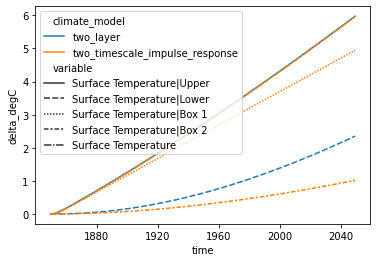

In [6]:
res.filter(variable="Surface Temperature*").lineplot(
    hue="climate_model", style="variable"
)